In [1]:
import os
import sys
import random
import shutil
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, "../utils")
import utils
import importlib
importlib.reload(utils)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import torchvision.transforms as T
import seaborn as sns
sns.set_theme()

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [3]:
utils.set_random_seed()

# Assignment 7

 - Implement the (adapted) TriNet Siamese model:
    - Resnet18 convolutional backbone (until AvgPool) 
    - Fully connected frontend to obtain desired embedding
    - Normalization layer
 

In [4]:
from siamese_model import  TriNet_Siamese_model

- Use *Labeled Faces in the Wild* (LFW) dataset (http://vis-www.cs.umass.edu/lfw/)
    - Over 13000 images
    - Train and test set

In [5]:
class TripletLFWDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset, min_occur=2):
        """ Dataset initializer"""
        self.arange = np.arange(len(dataset))
        self.data = torch.stack([d for d,_ in tqdm(dataset)])
        self.labels = torch.Tensor([l for _,l in tqdm(dataset)])
        # remove faces that only have one occurence 
        label, count = torch.unique(self.labels, return_counts=True)
        # discard based on amount of occurences 
        vals = label[count>=min_occur]
        idx = torch.isin(self.labels,vals)
        self.data = self.data[idx]
        self.labels = self.labels[idx]
        print(f"Length of data before removing faces that occur less than {min_occur} times:", len(dataset))
        print(f"Length of data after removing faces that occur less than {min_occur} times:", len(self.data))
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.data)

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.data[i], self.labels[i]

        # lists for positives and negatives
        # get first element of torch where
        pos_ids = torch.where((self.labels == anchor_lbl))[0]
        # remove same index s.t. lower function does not take pos_id as same index
        pos_ids = pos_ids[pos_ids != i]


        # get first element of torch where
        neg_id = torch.where(self.labels != anchor_lbl)[0]
        
        
        # random positive and negative
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()  
        pos_img, pos_lbl = self.data[pos_id], self.labels[pos_id]
        neg_img, neg_lbl = self.data[neg_id], self.labels[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

### To have better "clusters" in the visualization afterwards, throw out faces that occur less then the defined min_occurences below

In [6]:
train_data = datasets.LFWPeople("./data", split="train", transform=T.ToTensor(), download=True)
test_data = datasets.LFWPeople("./data", split="test", transform=T.ToTensor(), download=True)

# set 80% split of train and test set
split = int(len(train_data) * 0.8)
train_split, valid_split = torch.utils.data.random_split(train_data, [split, len(train_data) - split])

min_occurences = 5

triplet_train = TripletLFWDataset(train_split, min_occur=min_occurences)
triplet_valid = TripletLFWDataset(valid_split, min_occur=min_occurences)
triplet_test = TripletLFWDataset(test_data, min_occur=min_occurences)

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=triplet_train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=triplet_valid, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=triplet_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 7620/7620 [00:13<00:00, 551.52it/s]


Length of data before removing faces that occur less than 5 times: 7620
Length of data after removing faces that occur less than 5 times: 3259


100%|██████████| 1905/1905 [00:03<00:00, 542.18it/s]


Length of data before removing faces that occur less than 5 times: 1905
Length of data after removing faces that occur less than 5 times: 516


100%|██████████| 3708/3708 [00:06<00:00, 581.16it/s]


Length of data before removing faces that occur less than 5 times: 3708
Length of data after removing faces that occur less than 5 times: 1549


In [7]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        cur_losses = 0
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)}, Valid Loss={round(np.mean(cur_losses),5)}")

                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [8]:
import triplet_losses

 - Train the following models:
    - TriNet initialized with random weights
    - Fine-tuned TriNet (pretrained ResNet and then fine-tuned)
    - Train best of the above models, but using semi-hard negative mining strategy (https://arxiv.org/abs/1503.03832)


### Default Siamese Model with Normal Triplet Loss

In [27]:
emb_dim = 128
model_default = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
criterion = triplet_losses.TripletLoss(margin=0.2)
trainer_default = Trainer(model=model_default, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=5000)

trainer_default.fit()

Train Iter 4999: Loss=0.02485, Valid Loss=0.01239:   0%|          | 0/5000 [07:51<?, ?it/s]


In [8]:
# save model
# utils.save_model(model_default, trainer_default.optimizer, 5000, [trainer_default.train_loss,trainer_default.valid_loss], model_name="Default")

# load model
emb_dim=128
model_default = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
optimizer = torch.optim.Adam(model_default.parameters(), lr=3e-4, weight_decay=1e-5)

model_default, optim, train_loss, valid_loss = utils.load_model(model_default, optimizer, "./models/checkpoint_TriNet_Siamese_modelDefault_epoch_5000.pth")

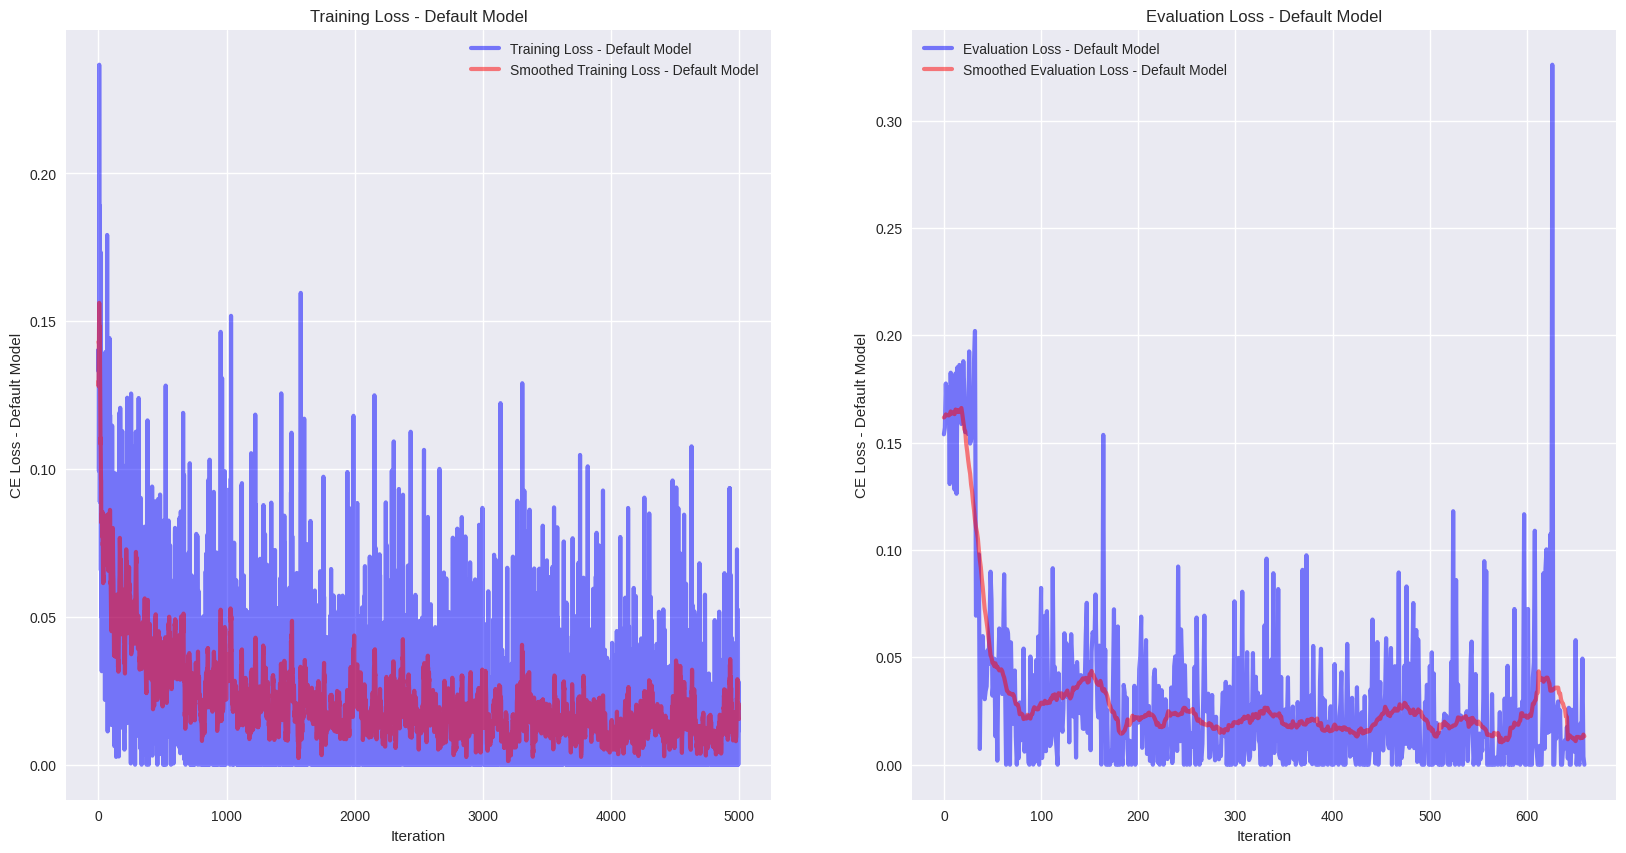

In [29]:
mode_default = "Loss - Default Model"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_default.train_loss, trainer_default.valid_loss, mode_default)

### Default Siamese Model with Semi Hard Negative Mining Triplet Loss

In [9]:
emb_dim = 128
model_default_mining = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
criterion = triplet_losses.TripletSemiHardLoss(margin=0.2)
trainer_default_mining = Trainer(model=model_default_mining, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=5000)

trainer_default_mining.fit()

Train Iter 4999: Loss=0.00629, Valid Loss=0.01815:   0%|          | 0/5000 [07:51<?, ?it/s]


In [9]:
# save model
# utils.save_model(model_default_mining, trainer_default_mining.optimizer, 5000, [trainer_default_mining.train_loss,trainer_default_mining.valid_loss], model_name="Default_Mining")

# load model
emb_dim=128
model_default_mining = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=True)
optimizer = torch.optim.Adam(model_default_mining.parameters(), lr=3e-4, weight_decay=1e-5)
model_default_mining, optim, train_loss, valid_loss = utils.load_model(model_default_mining, optimizer, "./models/checkpoint_TriNet_Siamese_modelDefault_Mining_epoch_5000.pth")

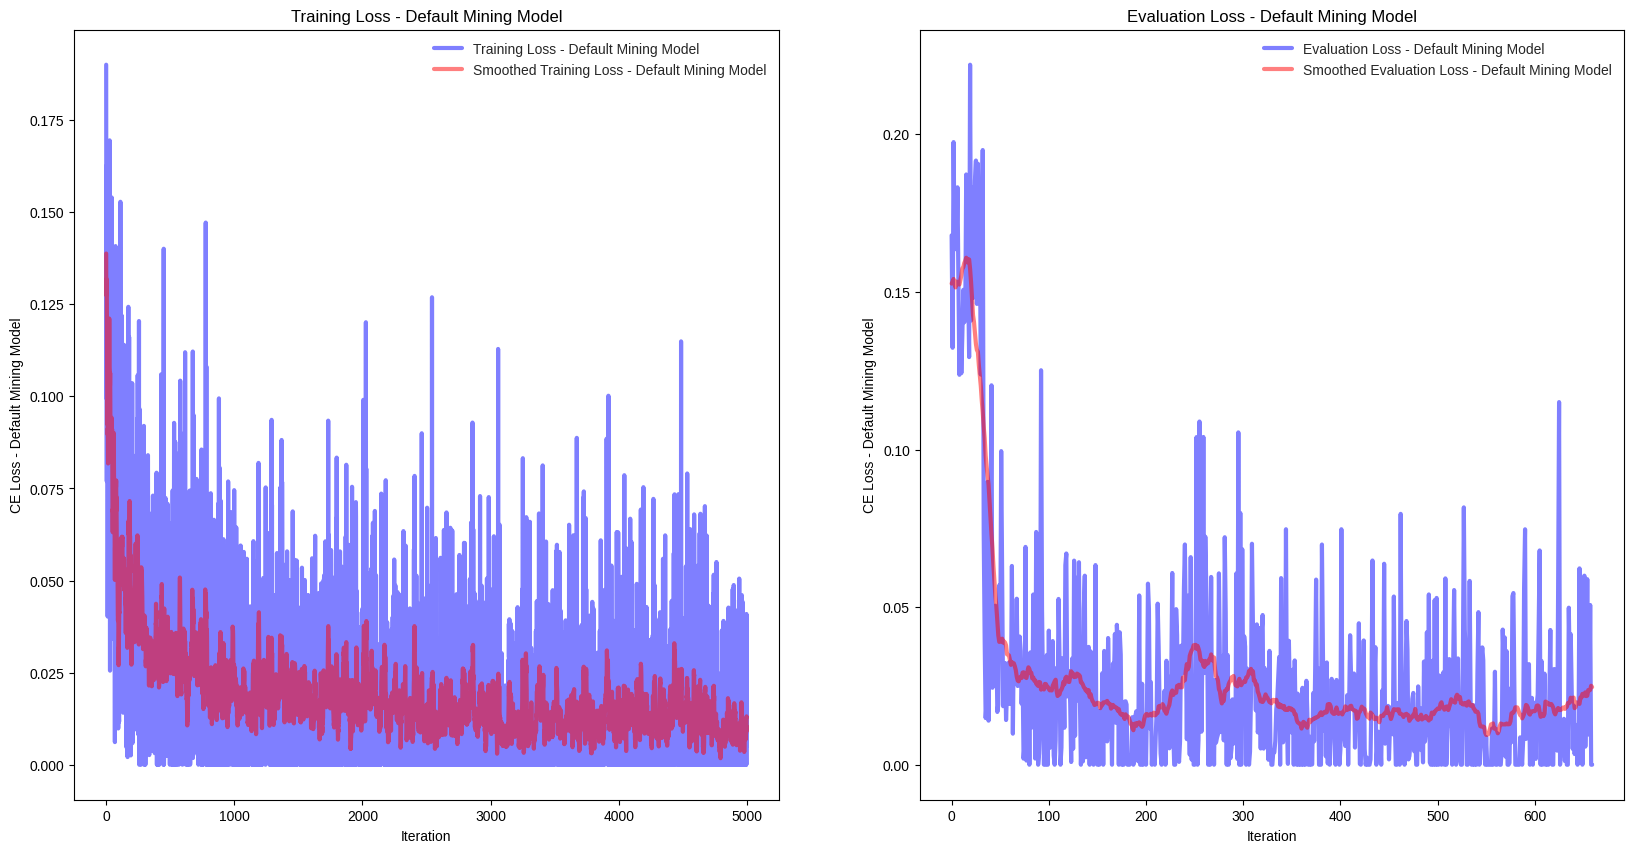

In [11]:
mode_default = "Loss - Default Mining Model"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_default_mining.train_loss, trainer_default_mining.valid_loss, mode_default)

### Pretrained Siamese Model with normal Triplet Loss

In [40]:
emb_dim = 128
model_pretrained = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=True)
criterion = triplet_losses.TripletLoss(margin=0.2)
trainer_pretrained = Trainer(model=model_pretrained, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=5000)

trainer_pretrained.fit()


Train Iter 4913: Loss=0.0, Valid Loss=0.014:   0%|          | 0/5000 [07:44<?, ?it/s]      

In [10]:
# save model
# utils.save_model(model_pretrained, trainer_pretrained.optimizer, 5000, [trainer_pretrained.train_loss,trainer_pretrained.valid_loss], model_name="Pretrained")

# load model
emb_dim=128
model_pretrained = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=True)
optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=3e-4, weight_decay=1e-5)
model_pretrained, optim, train_loss, valid_loss = utils.load_model(model_pretrained, optimizer, "./models/checkpoint_TriNet_Siamese_modelPretrained_epoch_5000.pth")

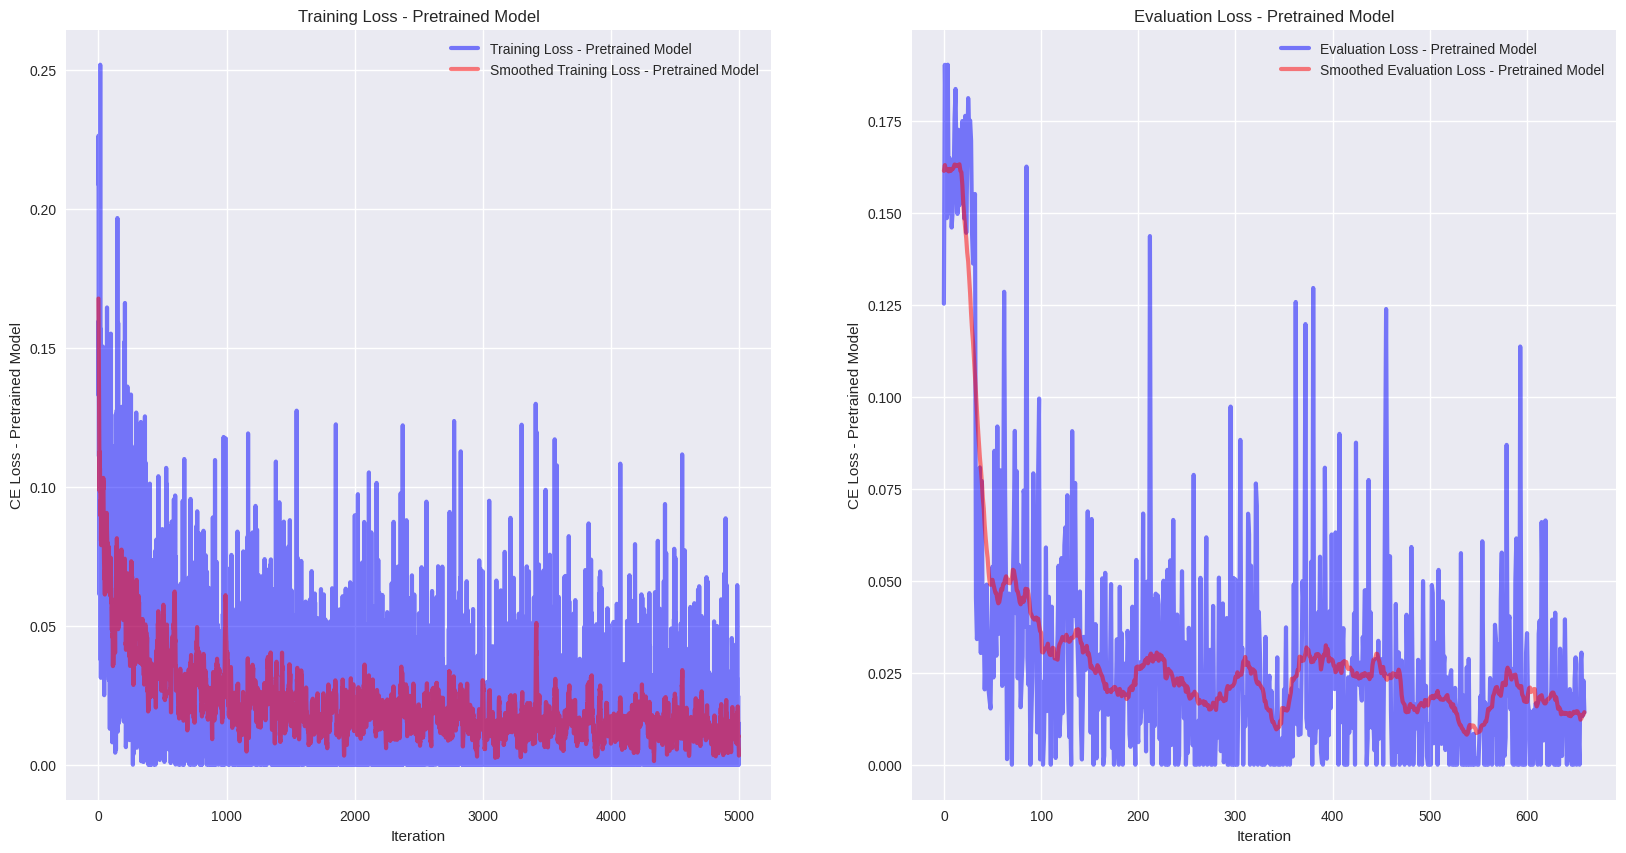

In [45]:
mode_pretrained = "Loss - Pretrained Model"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_pretrained.train_loss, trainer_pretrained.valid_loss, mode_pretrained)

#### Both models default and pretrained perform similarly pretrained, but the default seems to fluctuate less in Evaluation (validation) loss. Therefore we prefer pretrained

In [9]:
emb_dim = 128
model_pretr_mining = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=True)
criterion = triplet_losses.TripletSemiHardLoss()
trainer_pre_mining = Trainer(
    model=model_pretr_mining, criterion=criterion, train_loader=train_loader, 
    valid_loader=valid_loader, n_iters=5000)

trainer_pre_mining.fit()

Train Iter 4999: Loss=0.0, Valid Loss=0.01488:   0%|          | 0/5000 [07:51<?, ?it/s]    


In [11]:
# save model
# utils.save_model(model_pretr_mining, trainer_pre_mining.optimizer, 5000, [trainer_pre_mining.train_loss, trainer_pre_mining.valid_loss], model_name="Pretrained_Mining")

# load model
emb_dim=128
model_pretr_mining = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=True)
optimizer = torch.optim.Adam(model_pretr_mining.parameters(), lr=3e-4, weight_decay=1e-5)
model_pretr_mining, optim, pre_mining_train_loss, pre_mining_valid_loss = utils.load_model(model_pretr_mining, optimizer, "./models/checkpoint_TriNet_Siamese_modelPretrained_Mining_epoch_5000.pth")

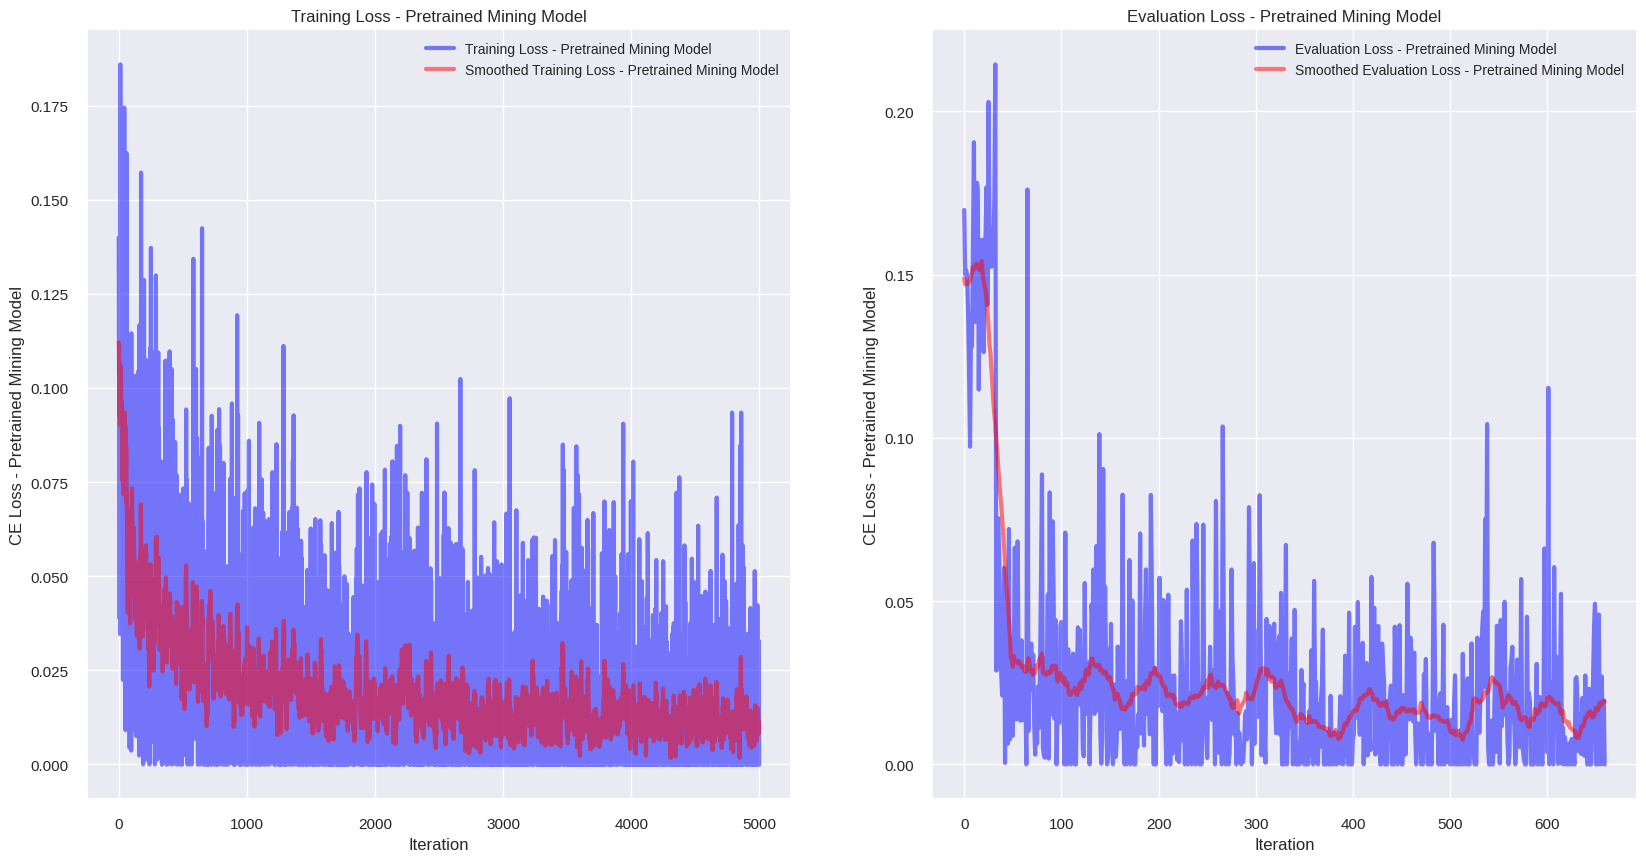

In [15]:
mode_pretr_mining = "Loss - Pretrained Mining Model"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_pre_mining.train_loss, trainer_pre_mining.valid_loss, mode_pretr_mining)

 - Compare visualized embeddings


In [17]:
def get_highest_occ_labels(test_loader, N=25):
    
    # set arbitrary label entries
    occ_dict = {i: 0 for i in range(10000)}

    with torch.no_grad():
        for (_, _, _), (label,_, _) in tqdm(test_loader):

            for l in label:
                occ_dict[int(l)]+=1

    occ_dict = dict(sorted(occ_dict.items(), key=lambda x: x[1], reverse=True))
    occ_dict = dict(list(occ_dict.items())[:N])

    return torch.tensor(list(occ_dict.keys()), dtype=torch.int16)


def get_embeddings(test_loader, model, target_index = None):
    # target index controls if we want to take all targets or only certain targets
    imgs_flat = []
    embs = []
    labels = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model =  model.to(device)

    with torch.no_grad():
        for (anchor, pos, neg), (label,_, _) in tqdm(test_loader):

            if target_index!= None:
                hits = torch.isin(label, target_index)
                if hits.any():
                    anchor = anchor.to(device)
                    pos = pos.to(device)
                    neg = neg.to(device)
                    anchor_emb, _ , _ = model.forward(anchor, pos, neg)
                    
                    labels.append(label[hits])
                    embs.append(anchor_emb[hits].cpu())
                    imgs_flat.append(anchor[hits].cpu().flatten(1))

            else:
                anchor = anchor.to(device)
                pos = pos.to(device)
                neg = neg.to(device)
                anchor_emb, _ , _ = model.forward(anchor, pos, neg)
                
                labels.append(label)
                embs.append(anchor_emb.cpu())
                imgs_flat.append(anchor.cpu().flatten(1))

    labels = np.concatenate(labels)
    embs = np.concatenate(embs)
    imgs_flat = np.concatenate(imgs_flat)

    return labels, embs, imgs_flat

In [16]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], c=COLORS[i % len(COLORS)], label=legend[idx][0])
    ax.legend(loc="best")

def name_from_label(labels):
    classes = np.array(list(test_data.class_to_idx.keys()))
    labels_int = [int(label) for label in labels.tolist()]
    return classes[labels_int]

def plot_reduc_emb(dim_reduc_fn, dim_reduc_name, N, model, model_name, loader, ax):

    occ_dict = get_highest_occ_labels(loader, N)
    labels, embs, imgs_flat = get_embeddings(loader, model, occ_dict)
    reduc_imgs = dim_reduc_fn(n_components=2).fit_transform(imgs_flat)
    reduc_embs = dim_reduc_fn(n_components=2).fit_transform(embs)
    
    class_names = name_from_label(labels)

    display_projections(reduc_imgs, labels, ax=ax[0], legend=class_names)
    ax[0].set_title(f"{dim_reduc_name} Proj. of Images - {model_name}")
    display_projections(reduc_embs, labels, ax=ax[1], legend=class_names)
    ax[1].set_title(f"{dim_reduc_name} Proj. of Embeddings - {model_name}")

100%|██████████| 97/97 [00:02<00:00, 44.69it/s]


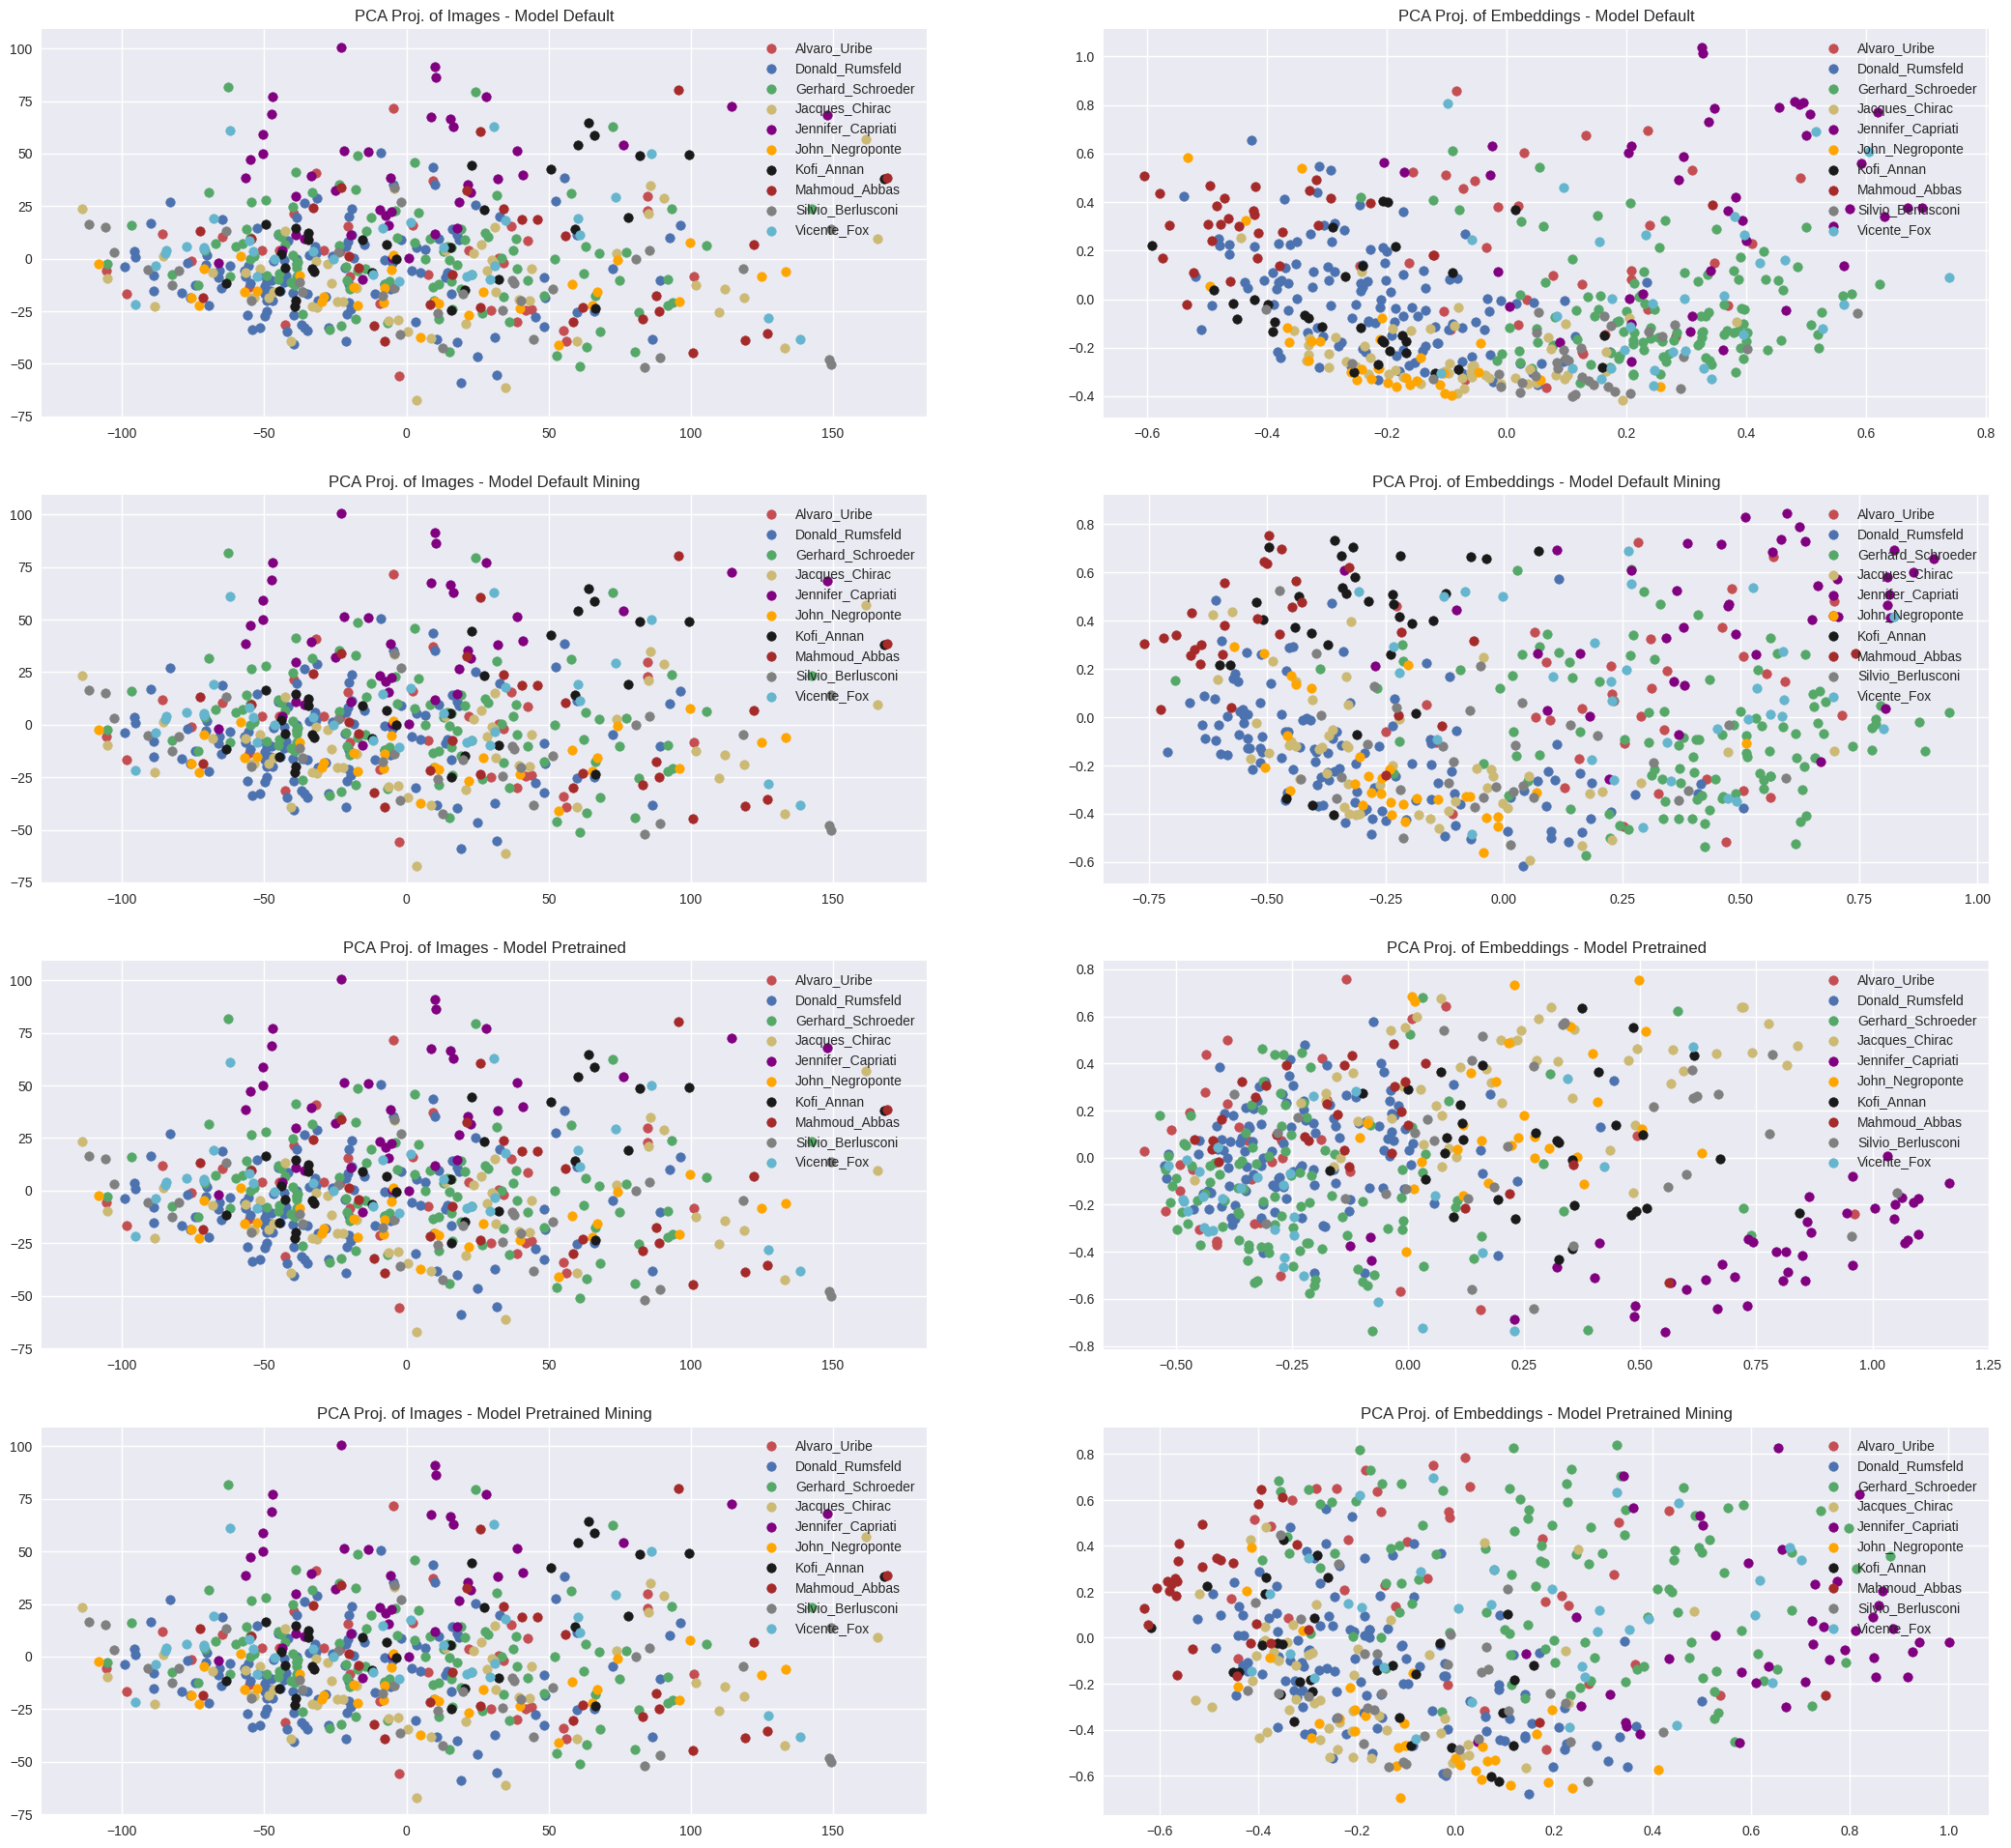

In [97]:
fig,ax = plt.subplots(4,2,figsize=(26,24))

plot_reduc_emb(PCA, "PCA", 10, model_default, "Model Default", test_loader, [ax[0,0], ax[0,1]])
plot_reduc_emb(PCA, "PCA", 10, model_default_mining, "Model Default Mining", test_loader, [ax[1,0], ax[1,1]])
plot_reduc_emb(PCA, "PCA", 10, model_pretrained, "Model Pretrained", test_loader, [ax[2,0], ax[2,1]])
plot_reduc_emb(PCA, "PCA", 10, model_pretr_mining, "Model Pretrained Mining", test_loader, [ax[3,0], ax[3,1]])
plt.show()

### PCA does not produce any reasonable clusters with some exceptions. 

100%|██████████| 97/97 [00:02<00:00, 44.58it/s]


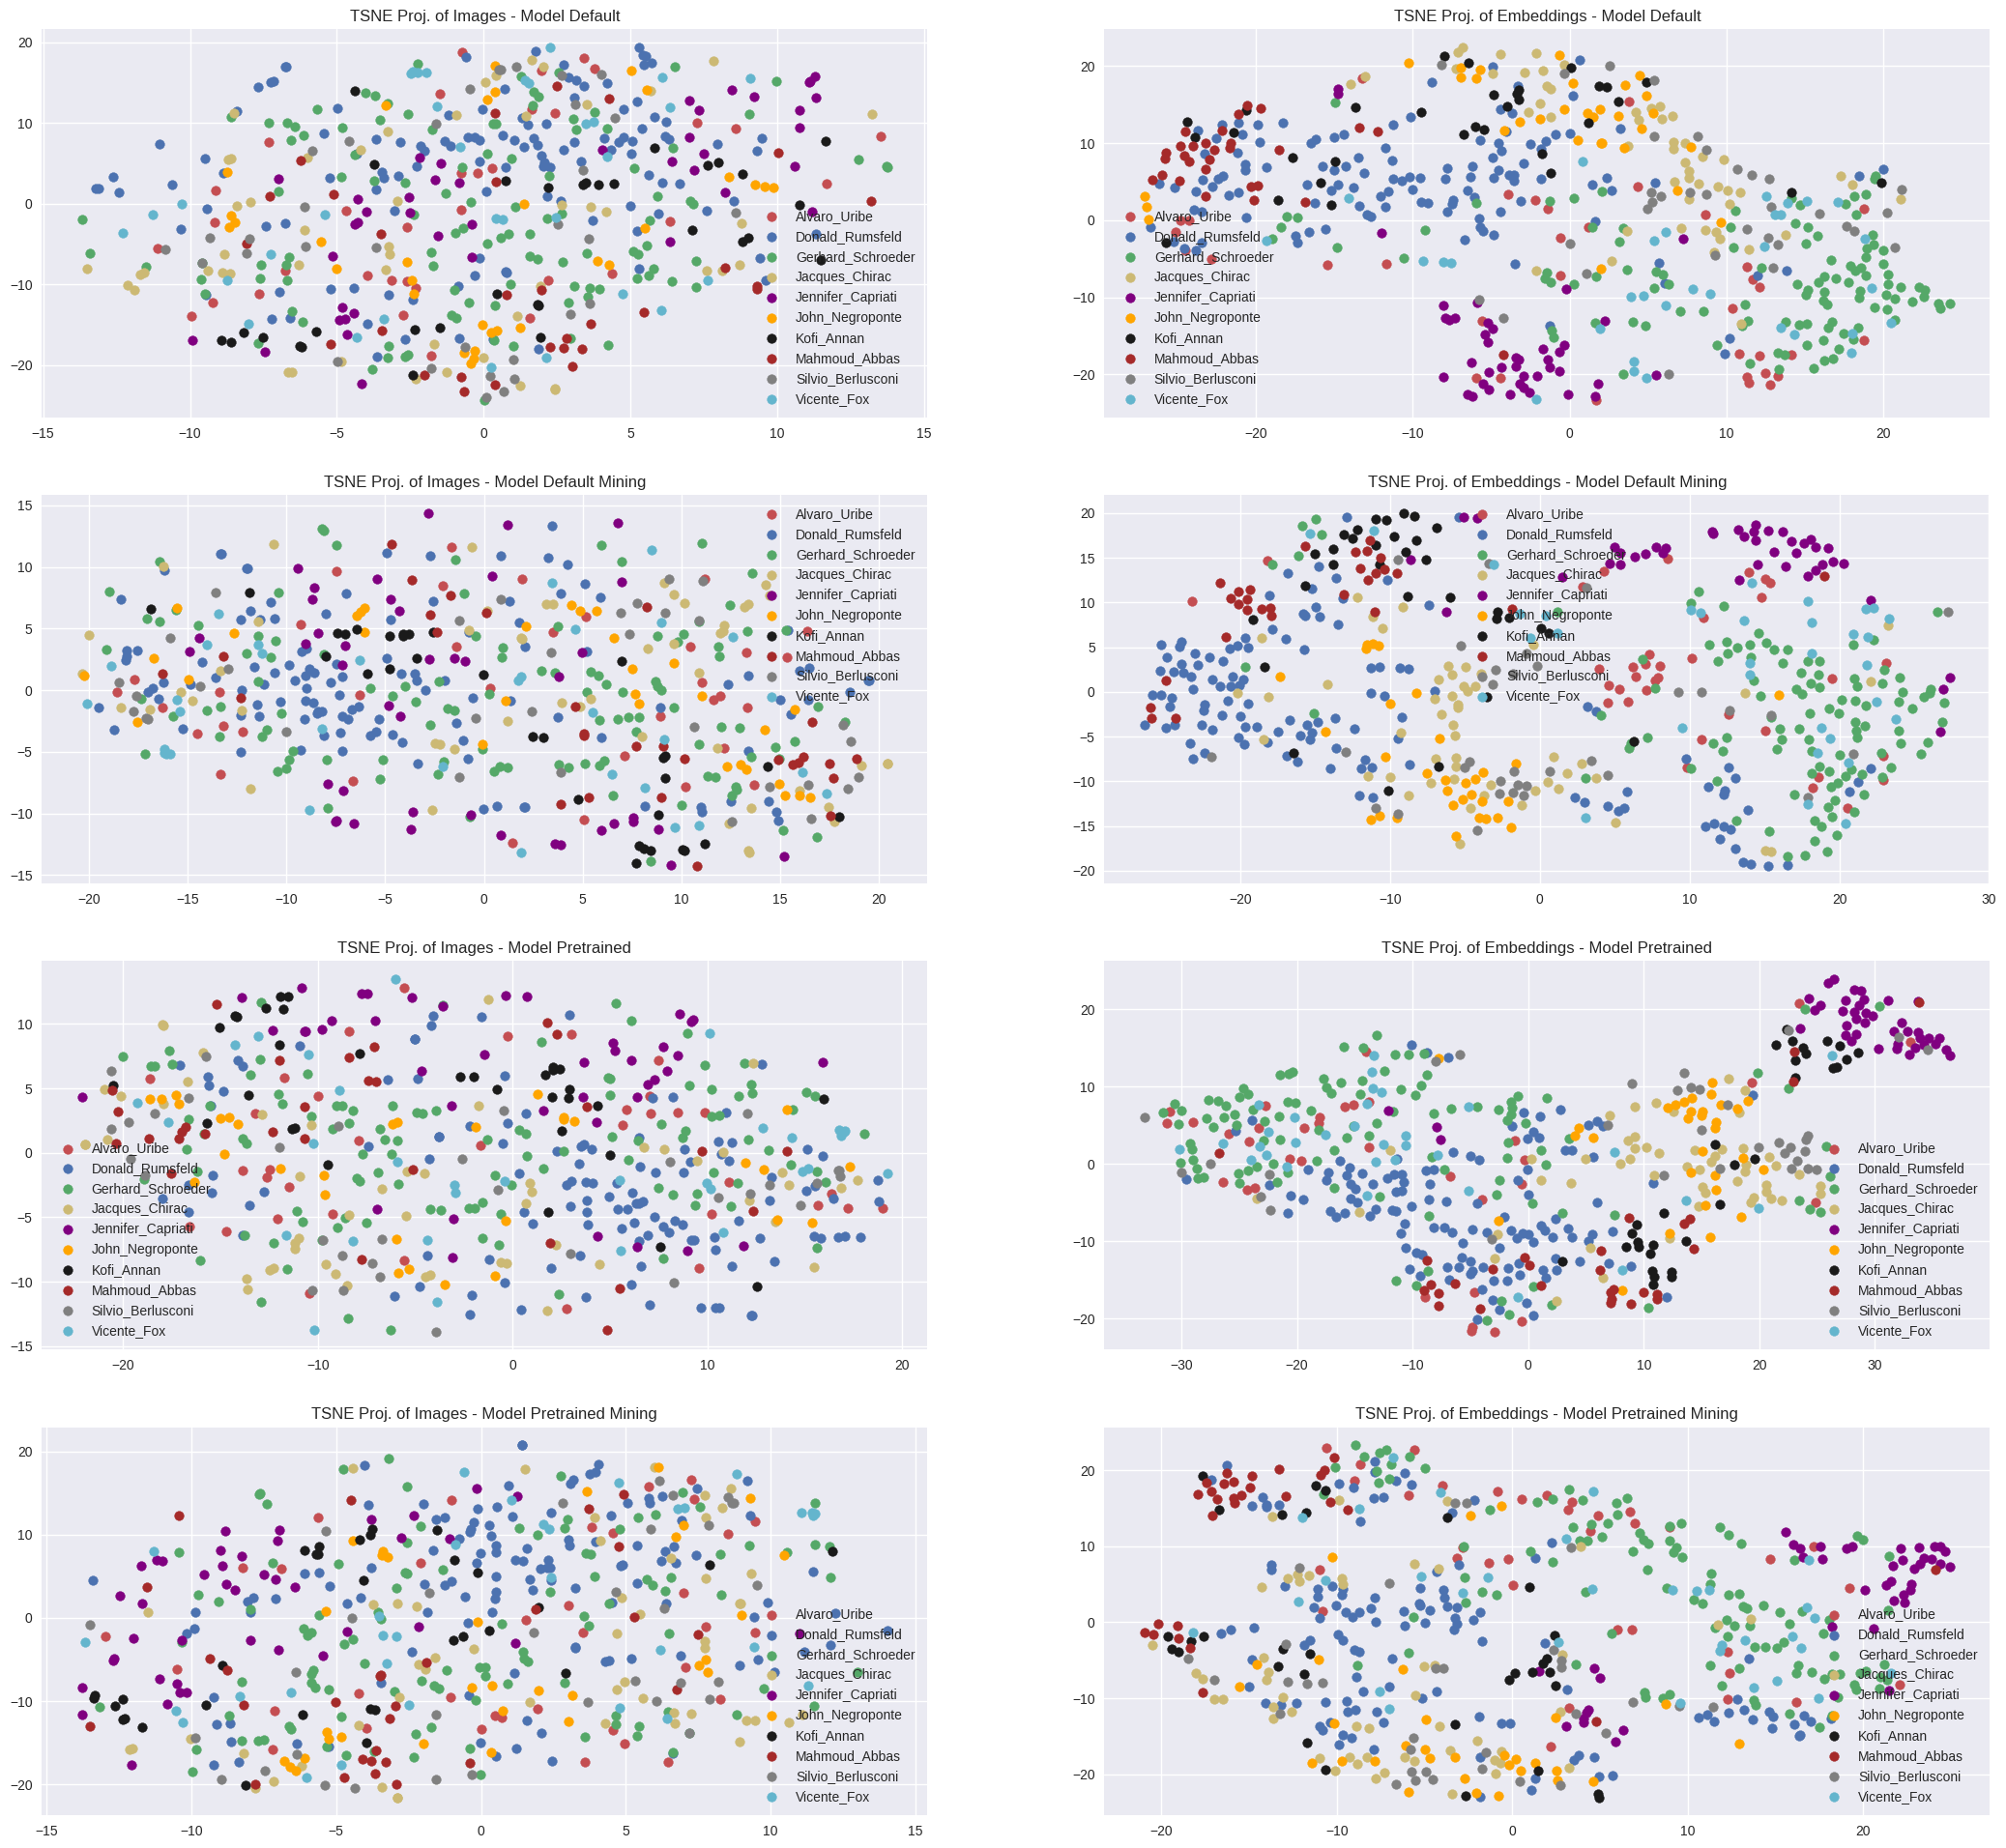

In [98]:
fig,ax = plt.subplots(4,2,figsize=(26,24))

plot_reduc_emb(TSNE, "TSNE", 10, model_default, "Model Default", test_loader, [ax[0,0], ax[0,1]])
plot_reduc_emb(TSNE, "TSNE", 10, model_default_mining, "Model Default Mining", test_loader, [ax[1,0], ax[1,1]])
plot_reduc_emb(TSNE, "TSNE", 10, model_pretrained, "Model Pretrained", test_loader, [ax[2,0], ax[2,1]])
plot_reduc_emb(TSNE, "TSNE", 10, model_pretr_mining, "Model Pretrained Mining", test_loader, [ax[3,0], ax[3,1]])
plt.show()

### Visually we can see that in general the TSNE Clusters are hard to recognize overall. We suppose this is because of the difficulty to distinctly cluster the large amount of faces (large amount of classes). This visualization reduces the face labels to 10 different faces, and even then the clustering is hard to recognize if there are distinct parts or classes merge.


 - Evaluate and compare the model performance (need not be thorough)

In [15]:
def get_test_embeddings(model, test_loader):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    imgs_flat = []
    embs = []
    labels = []
    with torch.no_grad():
        for (anchor, pos, neg), (label,_, _) in tqdm(test_loader):
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            anchor_emb, _ , _ = model.forward(anchor, pos, neg)
            
            labels.append(label)
            embs.append(anchor_emb.cpu())
            imgs_flat.append(anchor.cpu().flatten(1))

    labels = np.concatenate(labels)
    embs = np.concatenate(embs)
    imgs_flat = np.concatenate(imgs_flat)
    
    return labels, embs, imgs_flat

def compute_cluster_score(model, loader, model_name, N=25):

    # labels, embs, imgs_flat = get_test_embeddings(model, test_loader)

    occ_dict = get_highest_occ_labels(loader, N)
    labels, embs, imgs_flat = get_embeddings(loader, model, occ_dict)

    kmeans_imgs = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(imgs_flat)
    kmeans_embs = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(embs)

    ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
    ari_embs = adjusted_rand_score(labels, kmeans_embs.labels_)

    print(f"{model_name}: Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
    print(f"{model_name}: Clustering embeddings achieves ARI={round(ari_embs*100,2)}%")
    print(f"{model_name}: Compression ratio: {embs.shape[-1]}/{imgs_flat.shape[-1]}  = {round(embs.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

In [99]:
compute_cluster_score(model_default, test_loader, "Default Model", N=10)

100%|██████████| 97/97 [00:02<00:00, 44.96it/s]


Default Model: Clustering images achieves  ARI=3.89%
Default Model: Clustering embeddings achieves ARI=24.54%
Default Model: Compression ratio: 128/187500  = 0.07%


In [100]:
compute_cluster_score(model_default_mining, test_loader, "Default Model Mining", N=10)

100%|██████████| 97/97 [00:02<00:00, 44.85it/s]


Default Model Mining: Clustering images achieves  ARI=3.89%
Default Model Mining: Clustering embeddings achieves ARI=21.42%
Default Model Mining: Compression ratio: 128/187500  = 0.07%


In [101]:
compute_cluster_score(model_pretrained, test_loader, "Pretrained Model", N=10)

100%|██████████| 97/97 [00:02<00:00, 43.93it/s]


Pretrained Model: Clustering images achieves  ARI=3.89%
Pretrained Model: Clustering embeddings achieves ARI=20.51%
Pretrained Model: Compression ratio: 128/187500  = 0.07%


In [102]:
compute_cluster_score(model_pretr_mining, test_loader, "Pretrained Model Mining", N=10)

100%|██████████| 97/97 [00:02<00:00, 45.12it/s]


Pretrained Model Mining: Clustering images achieves  ARI=3.89%
Pretrained Model Mining: Clustering embeddings achieves ARI=14.43%
Pretrained Model Mining: Compression ratio: 128/187500  = 0.07%


### Judging by the Clustering scores we see that the Model with default weights (without pretrained weights) has the best score. As a test we took the first 10 faces that have the most occurences since there are many more faces with only 2 occurences and making small recognizable clusters would be hard (with color distribution as well). 

 - **Extra Point**: Train the same model as before, but with the following loss functions, and compare the results:
     - Angular Loss (https://arxiv.org/abs/1708.01682)
     - N-Pair Loss (https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html)

In [9]:
import importlib
importlib.reload(triplet_losses)

<module 'triplet_losses' from '/home/user/schwemme/CudaLab_SGR_PS/Session07/triplet_losses.py'>

In [15]:
emb_dim = 128
model_default_npair = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
n_pair_loss = triplet_losses.n_pair_loss()
trainer_default_npair = Trainer(model=model_default_npair, criterion=n_pair_loss, train_loader=train_loader, valid_loader=valid_loader, n_iters=5000)

trainer_default_npair.fit()

Train Iter 4999: Loss=0.36531, Valid Loss=0.35653:   0%|          | 0/5000 [07:55<?, ?it/s]


In [20]:
# save model
# utils.save_model(model_default_npair, trainer_default_npair.optimizer, 5000, [trainer_default_npair.train_loss, trainer_default_npair.valid_loss], model_name="Default_NPair")

# load model
emb_dim=128
model_default_npair = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
optimizer = torch.optim.Adam(model_default_npair.parameters(), lr=3e-4, weight_decay=1e-5)

model_default_npair, optim, train_loss, valid_loss = utils.load_model(model_default_npair, optimizer, "./models/checkpoint_TriNet_Siamese_modelDefault_NPair_epoch_5000.pth")

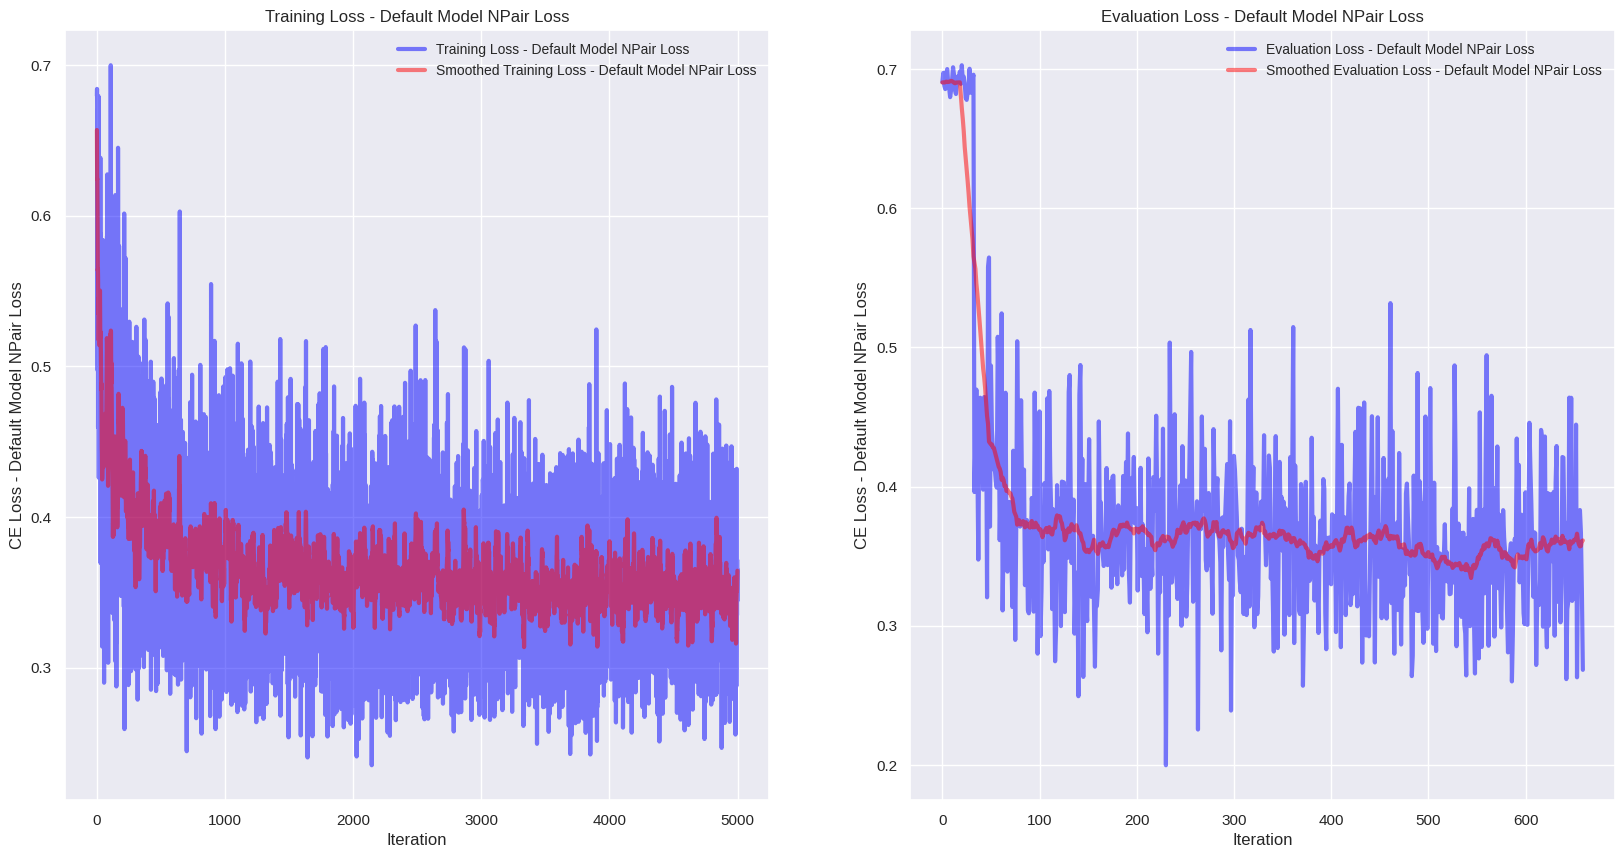

In [18]:
mode_default = "Loss - Default Model NPair Loss"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_default_npair.train_loss, trainer_default_npair.valid_loss, mode_default)

In [10]:
emb_dim = 128
model_default_angular = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
angular_loss = triplet_losses.angular_loss()
trainer_default_angular = Trainer(model=model_default_angular, criterion=angular_loss, train_loader=train_loader, valid_loader=valid_loader, n_iters=5000)

trainer_default_angular.fit()

Train Iter 4999: Loss=0.20835, Valid Loss=0.20049:   0%|          | 0/5000 [07:57<?, ?it/s]


In [22]:
# save model
# utils.save_model(model_default_angular, trainer_default_angular.optimizer, 5000, [trainer_default_angular.train_loss, trainer_default_angular.valid_loss], model_name="Default_Angular")

# load model
emb_dim=128
model_default_angular = TriNet_Siamese_model(emb_dim=emb_dim, pretrained=False)
optimizer = torch.optim.Adam(model_default_angular.parameters(), lr=3e-4, weight_decay=1e-5)

model_default_angular, optim, train_loss, valid_loss = utils.load_model(model_default_angular, optimizer, "./models/checkpoint_TriNet_Siamese_modelDefault_Angular_epoch_5000.pth")

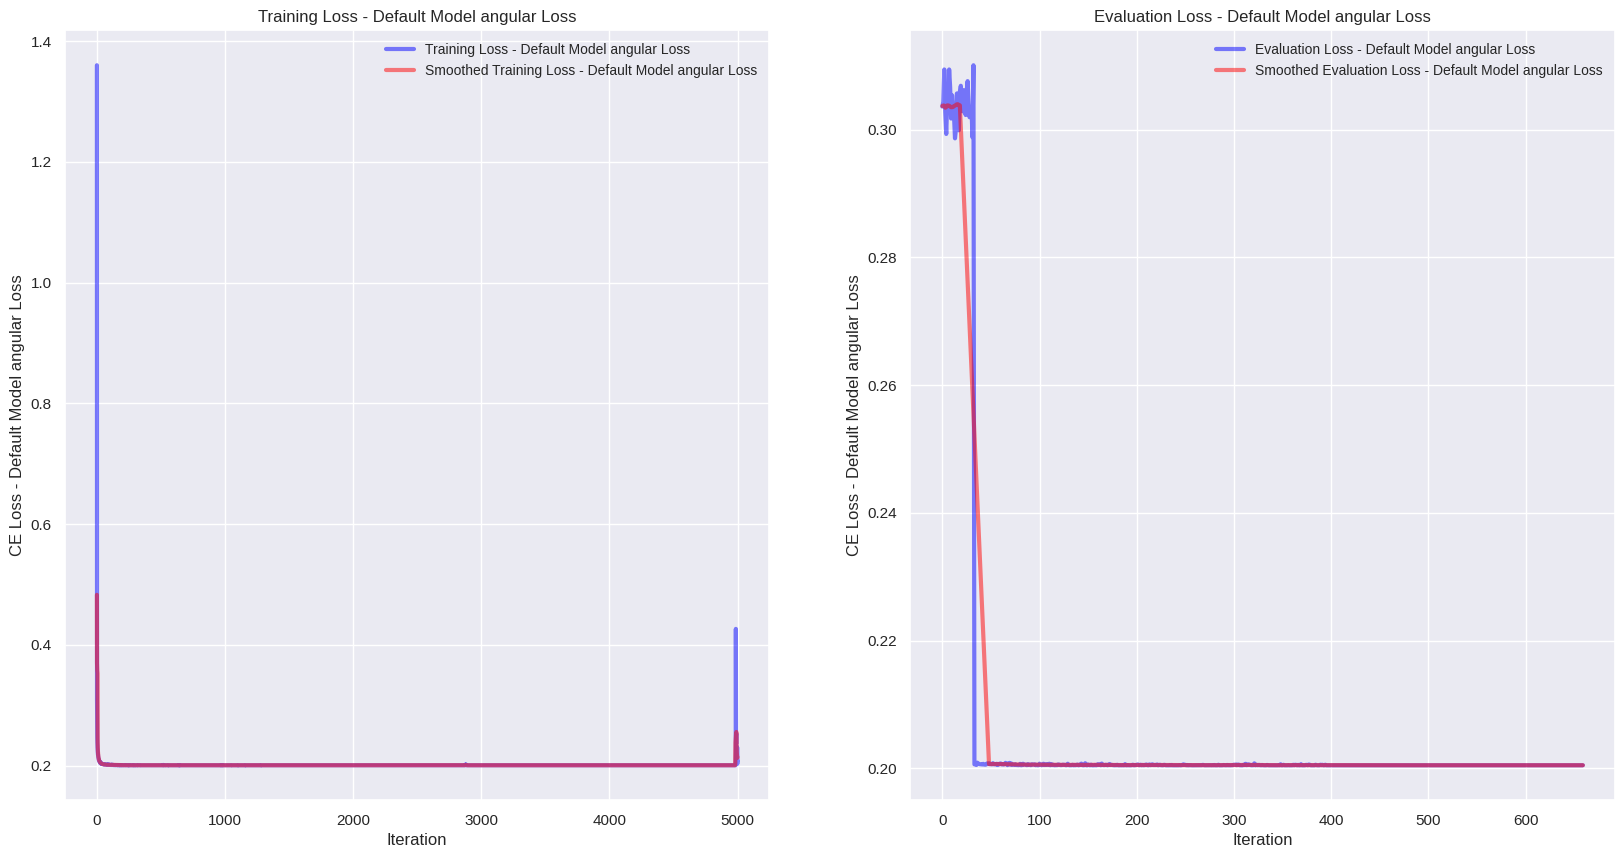

In [12]:
mode_default = "Loss - Default Model angular Loss"
_, ax = plt.subplots(1,2, figsize=(20,10))

utils.plot_results(ax, trainer_default_angular.train_loss, trainer_default_angular.valid_loss, mode_default)

100%|██████████| 97/97 [00:02<00:00, 43.38it/s]


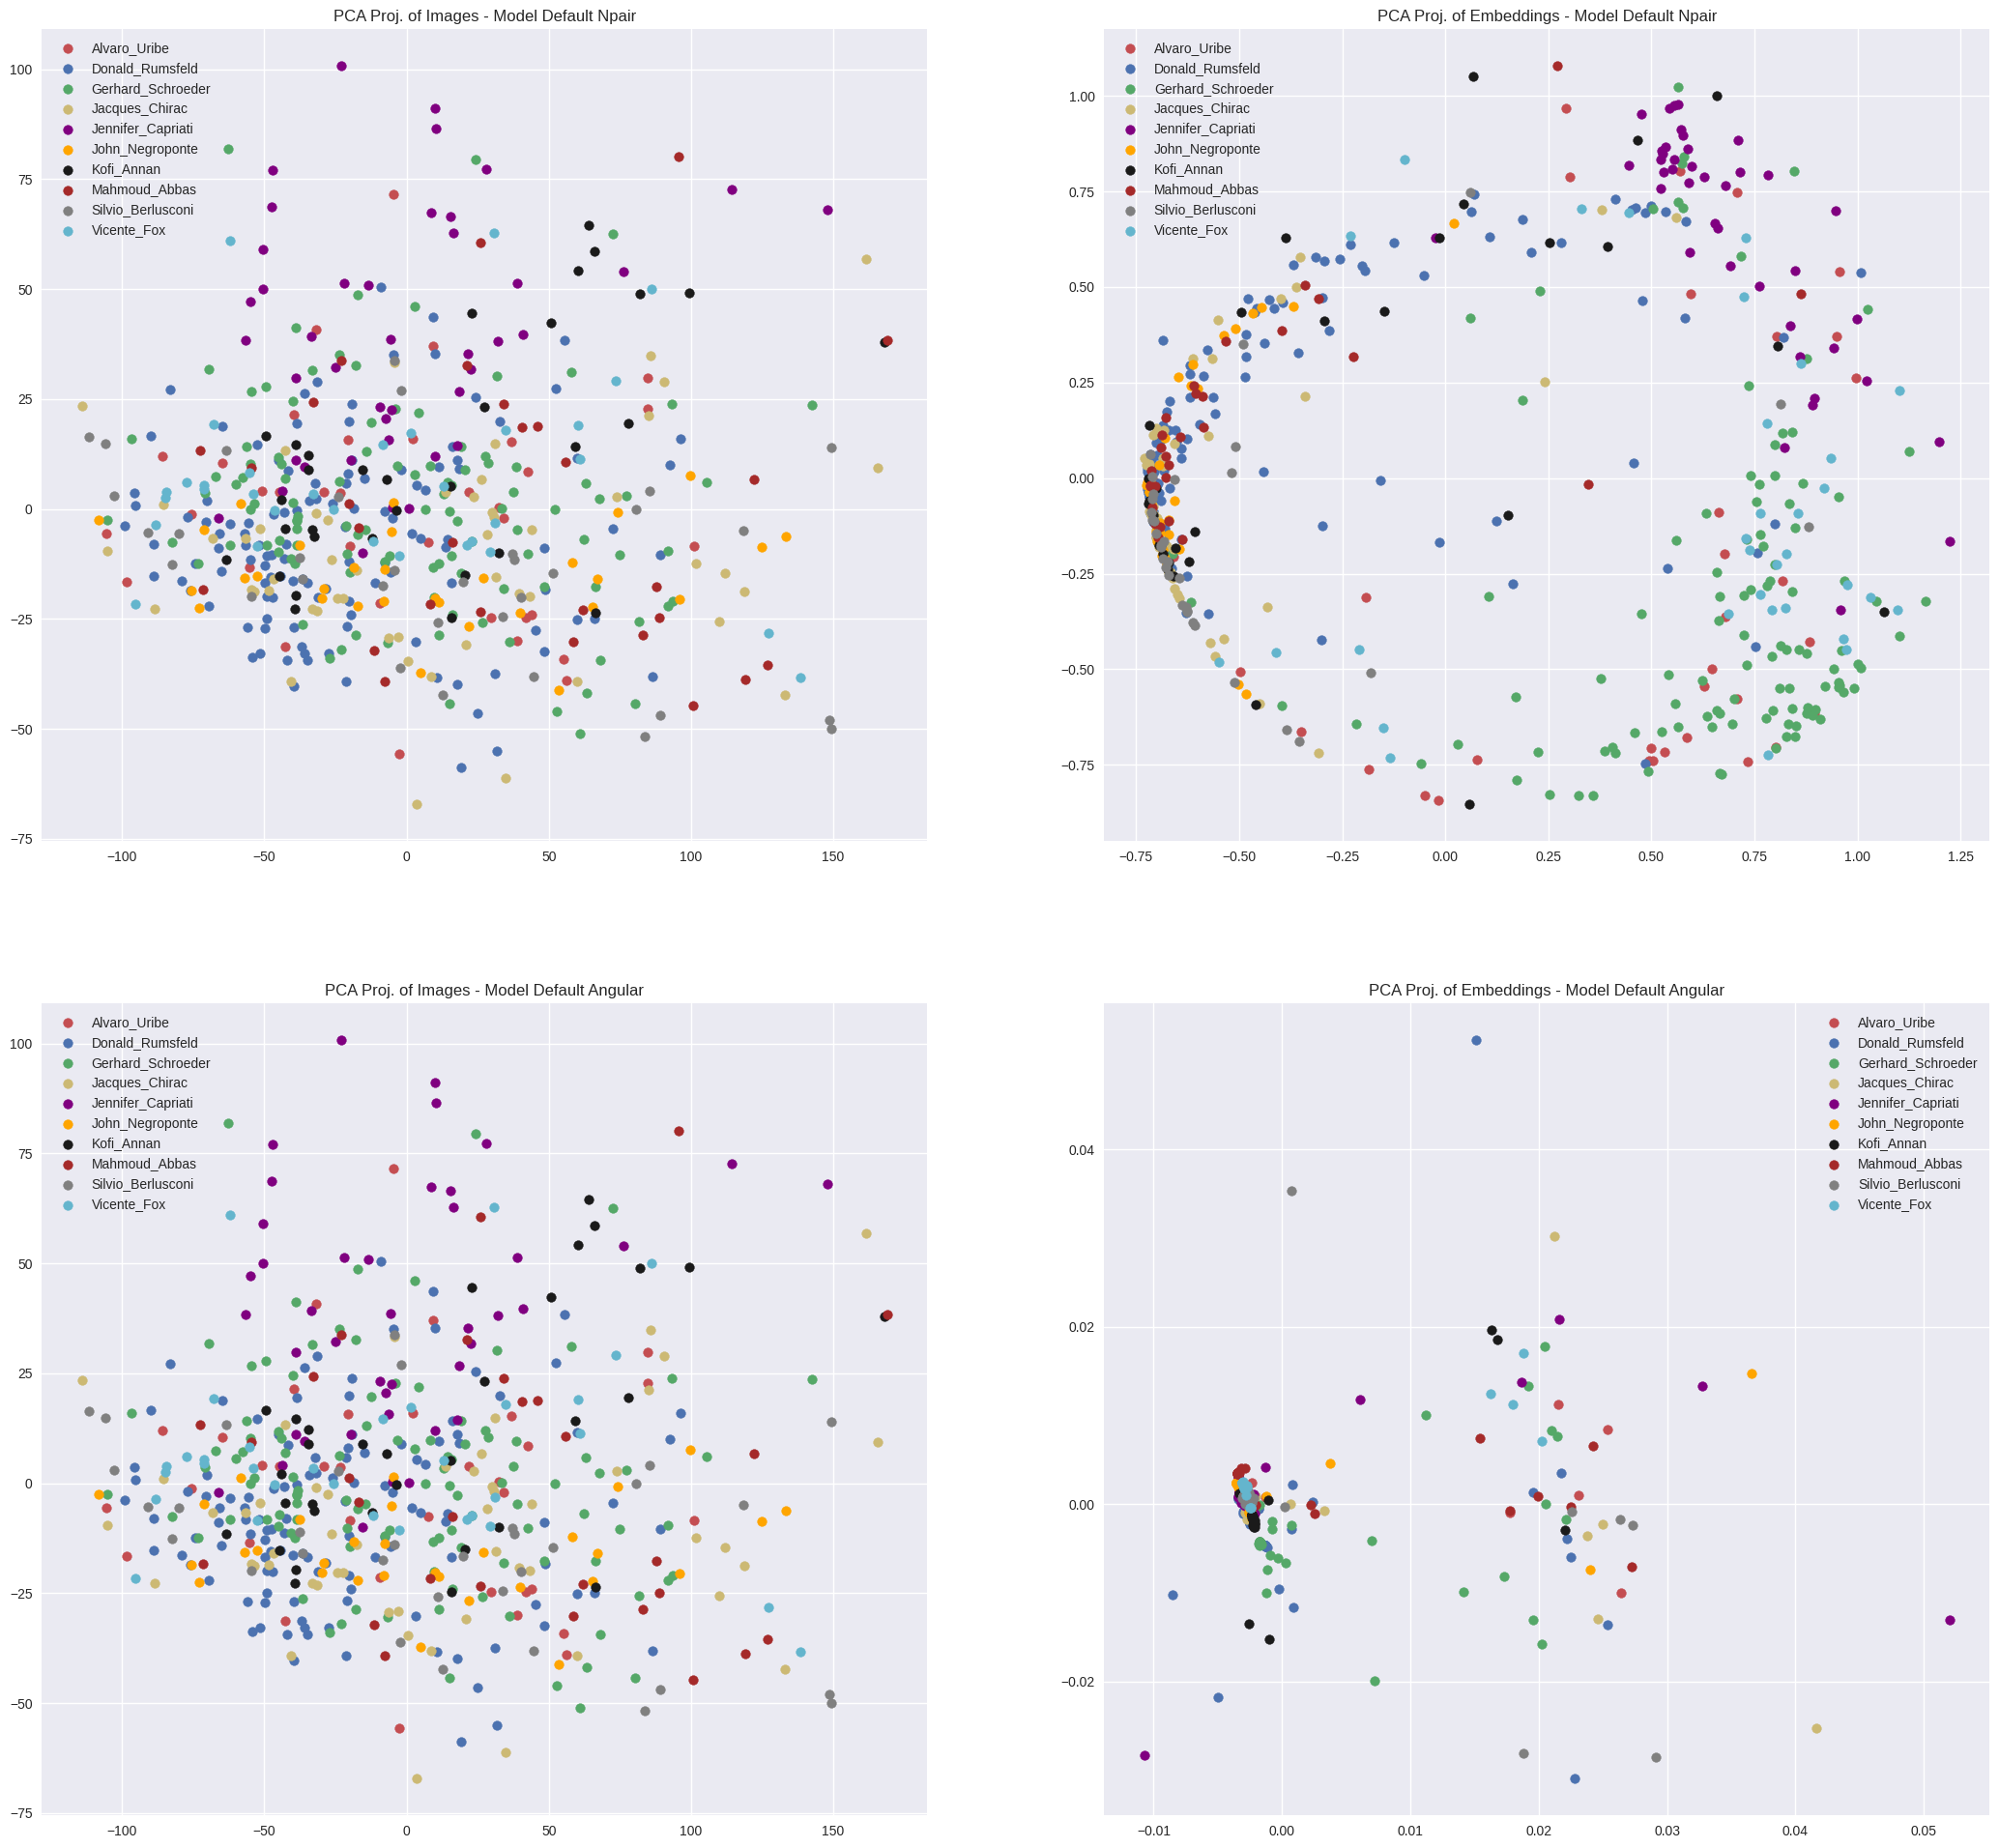

In [23]:
fig,ax = plt.subplots(2,2,figsize=(26,24))

plot_reduc_emb(PCA, "PCA", 10, model_default_npair, "Model Default Npair", test_loader, [ax[0,0], ax[0,1]])
plot_reduc_emb(PCA, "PCA", 10, model_default_angular, "Model Default Angular", test_loader, [ax[1,0], ax[1,1]])
plt.show()

### PCA Clusters are almost completely non informative.

100%|██████████| 97/97 [00:02<00:00, 44.01it/s]


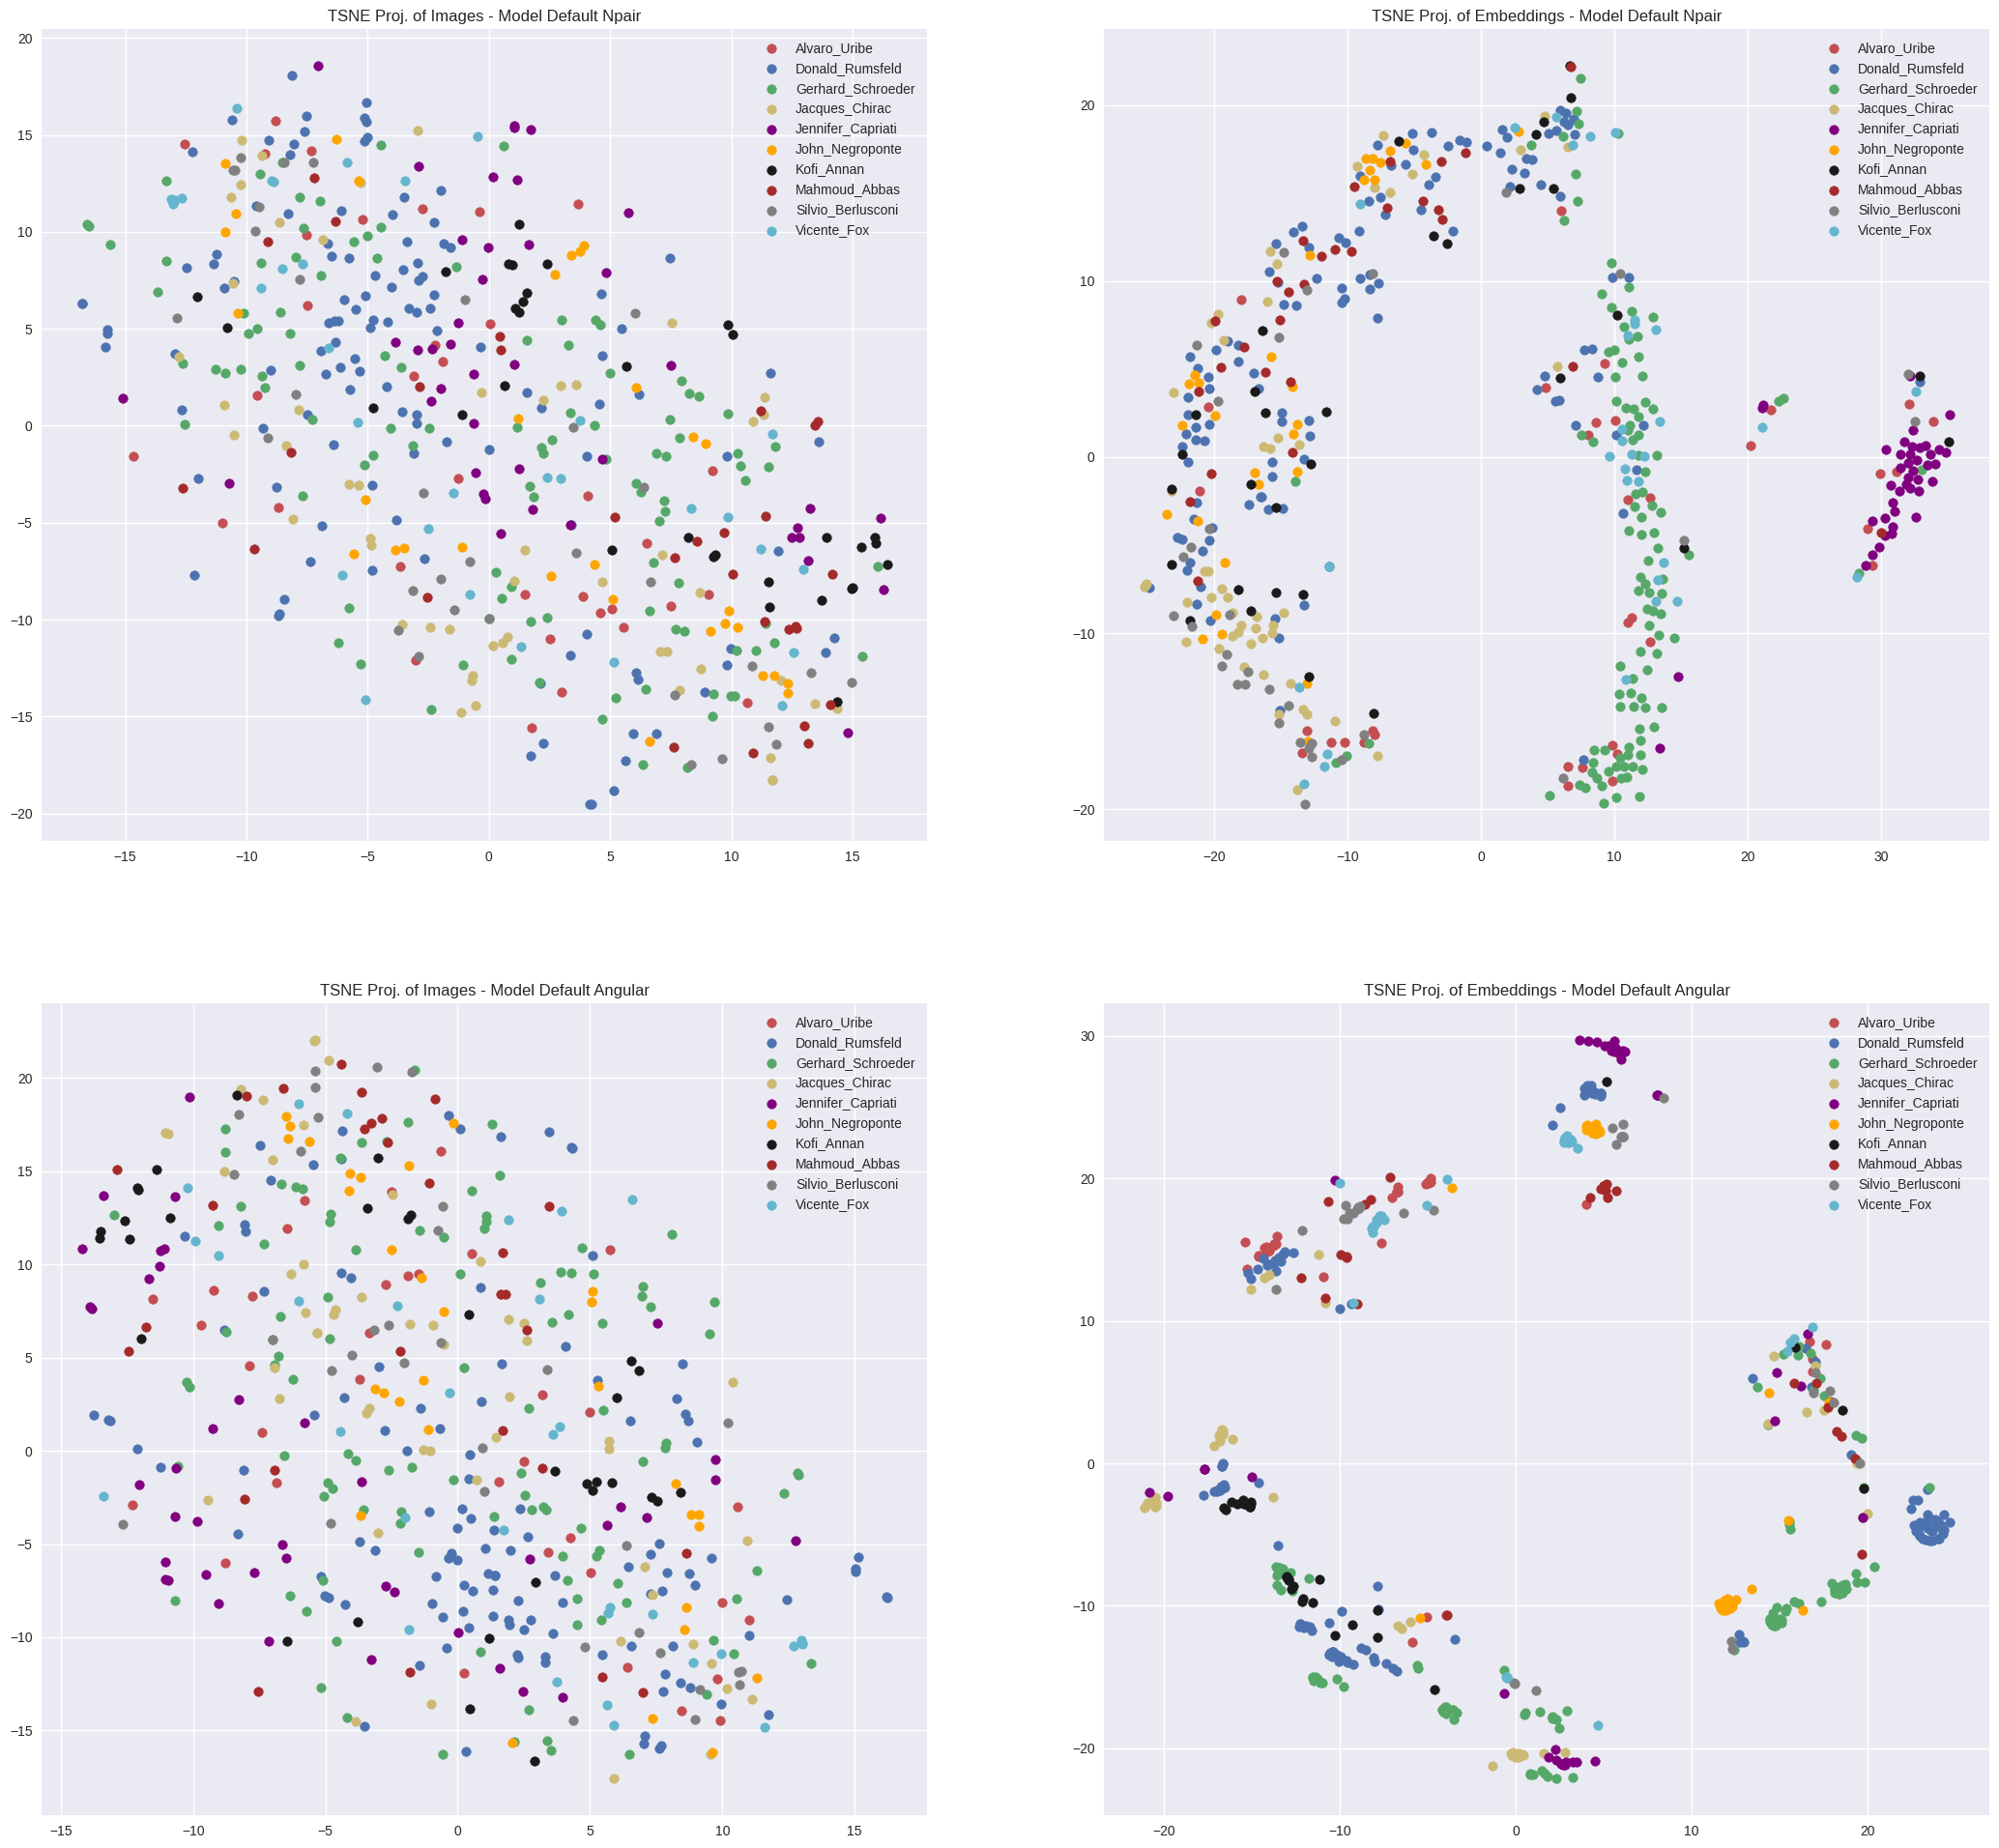

In [26]:
fig,ax = plt.subplots(2,2,figsize=(26,24))

plot_reduc_emb(TSNE, "TSNE", 10, model_default_npair, "Model Default Npair", test_loader, [ax[0,0], ax[0,1]])
plot_reduc_emb(TSNE, "TSNE", 10, model_default_angular, "Model Default Angular", test_loader, [ax[1,0], ax[1,1]])
plt.show()

### For TSNE the cluster shapes make sense for 10 different classes at least, but the intra Cluster Values are messed up. That is where NPair performs better (Green long clustering and violet).

In [25]:
compute_cluster_score(model_default_npair, test_loader, "Default Model NPair", N=10)
compute_cluster_score(model_default_angular, test_loader, "Default Model Angular", N=10)

100%|██████████| 97/97 [00:02<00:00, 45.34it/s]


Default Model NPair: Clustering images achieves  ARI=3.89%
Default Model NPair: Clustering embeddings achieves ARI=15.26%
Default Model NPair: Compression ratio: 128/187500  = 0.07%


100%|██████████| 97/97 [00:02<00:00, 43.70it/s]


Default Model Angular: Clustering images achieves  ARI=3.89%
Default Model Angular: Clustering embeddings achieves ARI=1.17%
Default Model Angular: Compression ratio: 128/187500  = 0.07%


### The Angular Loss seems to be very bad performing, while NPair loss is comparable to the prior used loss functions. 